# Chapters 7 and 8: Sentiment Analysis

## Data loading and preliminary inspection

We will be using popular `polarity dataset 2.0` collected by [Bo Pang and colleagues from Cornell Univeristy](http://www.cs.cornell.edu/people/pabo/movie-review-data/). Let's first read it in and inspect the data. This code is very similar to the routine applied to spam filtering in Chapter 2:

In [1]:
import os, codecs

def read_in(folder):
    files = os.listdir(folder)
    a_dict = {}
    for a_file in sorted(files):
        if not a_file.startswith("."):
            with codecs.open(folder + a_file, encoding='ISO-8859-1', errors ='ignore') as f:
                file_id = a_file.split(".")[0].strip()
                a_dict[file_id] = f.read()
            f.close()
    return a_dict

Now, when you download the dataset, it comes as two subfolders named `pos/` for all positive reviews and `neg/` for all negative ones, put within a folder called `review_polarity/txt_sentoken/`. If you don't change the folder names, you can simply read in the contents of all positive and negative reviews and put them in separate Python dictionaries of review titles mapped to the reviews content, using the method `read_in` from above.

Let's also print out the number of reviews in positive and negative dictionaries, as well as the very first positive and very first negative reviews in the dictionaries.

In [2]:
folder = "review_polarity/txt_sentoken/"
pos_dict = read_in(folder + "pos/")
print(len(pos_dict))
print(pos_dict.get(next(iter(pos_dict))))
neg_dict = read_in(folder + "neg/")
print(len(neg_dict))
print(neg_dict.get(next(iter(neg_dict))))

1000
films adapted from comic books have had plenty of success , whether they're about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there's never really been a comic book like from hell before . 
for starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid '80s with a 12-part series called the watchmen . 
to say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd . 
the book ( or " graphic novel , " if you will ) is over 500 pages long and includes nearly 30 more that consist of nothing but footnotes . 
in other words , don't dismiss this film because of its source . 
if you can get past the whole comic book thing , you might find another stumbling block in from hell's directors , albert and allen hughes . 
getting the hughes brothers to direct this seems almos

So far so good! There are a couple of observation that you can make at this point:

- The dataset is balanced between positive and negative reviews – both subsets have `1000` texts.
- Texts are already preprocessed: they are tokenized (i.e., each word token is separated from its neighbours by a white space, all words are converted to lower case).

What can you tell about the word content? Does the first positive review contain many positive words: i.e., if you didn't know it came from the `pos/` folder, would you be able to tell it was a positive one?

Let's next calculate some simple statistics, including: 
- Average length of a review in positive and negative subsets
- Average number of words per sentence
- Size of the vocabulary (unique words in each subset)
- *Diversity* of sentiment vocabulary – average number of times each word occurs in a text with a specific sentiment

Many of these calculations will rely on having words extracted from text. Since texts are already tokenized and words are separated by white spaces, it's a matter of simply splitting texts into words by white spaces – see method `tokenize`:

In [3]:
def tokenize(text):
    text.replace("\n", " ")
    return text.split()

def statistics(a_dict):
    length = 0
    sent_length = 0
    num_sents = 0
    vocab = []
    for review in a_dict.values():
        length += len(tokenize(review))
        sents = review.split("\n")
        num_sents += len(sents)
        for sent in sents:
            sent_length += len(tokenize(sent))
        vocab += tokenize(review)
    avg_length = float(length)/len(a_dict)
    avg_sent_length = float(sent_length)/num_sents
    vocab_size = len(set(vocab))
    diversity = float(length)/float(vocab_size)
    return avg_length, avg_sent_length, vocab_size, diversity
        
categories = ["Positive", "Negative"]
rows = []
rows.append(["Category", "Avg_Len(Review)", "Avg_Len(Sent)", "Vocabulary Size", "Diversity"])
stats = {}
stats["Positive"] = statistics(pos_dict)
stats["Negative"] = statistics(neg_dict)
for cat in categories:
    rows.append([cat, f"{stats.get(cat)[0]:.6f}", 
                f"{stats.get(cat)[1]:.6f}",
                f"{stats.get(cat)[2]:.6f}",
                f"{stats.get(cat)[3]:.6f}"])

columns = zip(*rows)
column_widths = [max(len(item) for item in col) for col in columns]
for row in rows:
    print(''.join(' {:{width}} '.format(row[i], width=column_widths[i]) 
                  for i in range(0, len(row))))   

 Category  Avg_Len(Review)  Avg_Len(Sent)  Vocabulary Size  Diversity 
 Positive  787.051000       23.191531      36805.000000     21.384350 
 Negative  705.630000       21.524266      34542.000000     20.428174 


As it shows, positive reviews are overall longer than negative ones; they also have longer sentences with larger and more diverse vocabularies. Let's see how many words there are in overlap between positive and negative vocabularies:

In [4]:
def vocab_difference(list1, list2):
    vocab1 = []
    vocab2 = []
    for rev in list1:
        vocab1 += tokenize(rev)
    for rev in list2:
        vocab2 += tokenize(rev)
    return sorted(list(set(vocab1) - set(vocab2)))

pos_wordlist = pos_dict.values()
neg_wordlist = neg_dict.values()

print(vocab_difference(pos_wordlist, neg_wordlist)[1500:1600])
print(vocab_difference(neg_wordlist, pos_wordlist)[1500:1600])
print()
print(str(len(vocab_difference(pos_wordlist, neg_wordlist))) + " unique words in positive reviews only")
print(str(len(vocab_difference(neg_wordlist, pos_wordlist))) + " unique words in negative reviews only")

['asssss', 'assuaged', 'asthmatic', 'astin', 'astonishment', 'astor', "astronauts'", 'astronomer/writer', 'astronomical', 'astronomically', 'asuma', 'at-odds', 'atf', 'atheism', 'atheists', 'atkine', "atlanta's", "atlantic's", 'atlantis', "atlantis'", 'atmospheres', 'atmospherically', 'atmostpheric', 'atomizers', 'atone', 'atreus', 'atrophied', 'atrophy', 'attachs', 'attainable', "attanasio's", "attendant's", 'attendees', 'attention-grabbing', 'attentive', 'attentiveness', 'attest', 'attilla-looking', 'attractions', 'attractive-seeming', 'attractiveness', 'au/~koukoula/', 'auberjonois', 'audacious', 'audacious--and', 'audience--in', 'audience-friendly', 'audience-pleaser', 'audience-pleasing', 'audiotapes', 'auditioned', 'auditor', 'audre', 'aug', 'aughra', 'augment', "august's", 'augusts', 'aulon', 'aumont', 'aunjanue', 'auntie', 'aural', 'aurally', 'aurelien', 'aurelius', "aurelius'", 'auriga', 'auriol', 'aurora', 'auschwitz', 'austen-like', "australian's", 'australian/belgian', 'aut

There are $16378$ unique words in the `positive` dictionary and $14115$ unique words in the `negative` one.

So far, you've been looking at word forms – i.e., words like *movie* and *movies*, *like* and *liked* were considered as separate tokens in the statistics above. How much diversity is there in reviews when you take lemmas? Let's apply further NLP analysis and see how many word lemmas, not word forms (i.e., original tokens), there are in each subset.

First, import `spacy` and implement the method `lemmatize`, that, when the "switch" is turned on, will return lemmas rather than word tokens.

In [5]:
import spacy
nlp = spacy.load("en_core_web_md")

In [6]:
def lemmatize(sentence, switch):
    text = nlp(sentence.replace("\n", " "))
    if switch=="on":
        lemmas = [text[i].lemma_ for i in range(len(text))]
        return lemmas
    else:
        tokens = [text[i] for i in range(len(text))]
        return tokens

#print out the results and compare
print(lemmatize(pos_dict.get(next(iter(pos_dict))), "on")[:200])
print()
print(lemmatize(pos_dict.get(next(iter(pos_dict))), "off")[:200])

['film', 'adapt', 'from', 'comic', 'book', 'have', 'have', 'plenty', 'of', 'success', ',', 'whether', '-PRON-', 'be', 'about', 'superhero', '(', 'batman', ',', 'superman', ',', 'spawn', ')', ',', 'or', 'gear', 'toward', 'kid', '(', 'casper', ')', 'or', 'the', 'arthouse', 'crowd', '(', 'ghost', 'world', ')', ',', 'but', 'there', 'be', 'never', 'really', 'be', 'a', 'comic', 'book', 'like', 'from', 'hell', 'before', '.', ' ', 'for', 'starter', ',', '-PRON-', 'be', 'create', 'by', 'alan', 'moore', '(', 'and', 'eddie', 'campbell', ')', ',', 'who', 'bring', 'the', 'medium', 'to', 'a', 'whole', 'new', 'level', 'in', 'the', 'mid', "'", '80', 'with', 'a', '12-part', 'series', 'call', 'the', 'watchman', '.', ' ', 'to', 'say', 'moore', 'and', 'campbell', 'thoroughly', 'research', 'the', 'subject', 'of', 'jack', 'the', 'ripper', 'would', 'be', 'like', 'say', 'michael', 'jackson', 'be', 'start', 'to', 'look', 'a', 'little', 'odd', '.', ' ', 'the', 'book', '(', 'or', '"', 'graphic', 'novel', ',', '"

Since processing with `spacy` might take time, let's run it once and store the results in specific data structures as we did in the previous chapters:

In [7]:
def spacy_preprocess_reviews(source):
    source_docs = {}
    index = 0
    for review_id in source.keys():
        #to speed processing up, you can disable "ner" – Named Entity Recognition module of spaCy
        source_docs[review_id] = nlp(source.get(review_id).replace("\n", ""), disable=["ner"])
        if index>0 and (index%200)==0:
            print(str(index) + " reviews processed")
        index += 1
    print("Dataset processed")
    return source_docs

pos_docs = spacy_preprocess_reviews(pos_dict)
neg_docs = spacy_preprocess_reviews(neg_dict)

200 reviews processed
400 reviews processed
600 reviews processed
800 reviews processed
Dataset processed
200 reviews processed
400 reviews processed
600 reviews processed
800 reviews processed
Dataset processed


Now, let's calculate statistics as before, but this time taking lemmas rather than word tokens into account – intuitively, this should make the space of unique 'words' smaller:

In [8]:
def statistics_lem(source_docs):
    length = 0
    vocab = []
    for review_id in source_docs.keys():
        review_doc = source_docs.get(review_id)
        lemmas = []
        for token in review_doc:
            lemmas.append(token.lemma_)
        length += len(lemmas)
        vocab += lemmas
    avg_length = float(length)/len(source_docs)
    vocab_size = len(set(vocab))
    diversity = float(length)/float(vocab_size)
    return avg_length, vocab_size, diversity
        
categories = ["Positive", "Negative"]
rows = []
rows.append(["Category", "Avg_Len(Review)", "Vocabulary Size", "Diversity"])
stats = {}
stats["Positive"] = statistics_lem(pos_docs)
stats["Negative"] = statistics_lem(neg_docs)
for cat in categories:
    rows.append([cat, f"{stats.get(cat)[0]:.6f}", 
                f"{stats.get(cat)[1]:.6f}",
                f"{stats.get(cat)[2]:.6f}"])

columns = zip(*rows)
column_widths = [max(len(item) for item in col) for col in columns]
for row in rows:
    print(''.join(' {:{width}} '.format(row[i], width=column_widths[i]) 
                  for i in range(0, len(row))))

 Category  Avg_Len(Review)  Vocabulary Size  Diversity 
 Positive  818.722000       24432.000000     33.510232 
 Negative  737.379000       22839.000000     32.285958 


The difference gets considerably smaller, but you can still see that positive reviews are longer and more diverse than negative ones. What do you think it says about the nature of positive and negative reviews?

Let's now extract the non-overlapping lemmas from the positive and negative subsets. This requires you to modify the code for `vocab_difference` above slightly:

In [9]:
def vocab_lem_difference(source_docs1, source_docs2):
    vocab1 = []
    vocab2 = []
    for rev_id in source_docs1.keys():
        rev = source_docs1.get(rev_id)
        for token in rev:
            vocab1.append(token.lemma_)
    for rev_id in source_docs2.keys():
        rev = source_docs2.get(rev_id)
        for token in rev:
            vocab2.append(token.lemma_)
    return sorted(list(set(vocab1) - set(vocab2)))

print(str(len(vocab_lem_difference(pos_docs, neg_docs))) + " unique lemmas in positive reviews only")
print(str(len(vocab_lem_difference(neg_docs, pos_docs))) + " unique lemmas in negative reviews only")

9230 unique lemmas in positive reviews only
7637 unique lemmas in negative reviews only


Compare these numbers to the ones for word tokens above.

Finally, let's see if the number of unique adjectives and adverbs differs across the reviews with different polarity:

In [10]:
def vocab_pos_difference(source_docs1, source_docs2, pos):
    vocab1 = []
    vocab2 = []
    for rev_id in source_docs1.keys():
        rev = source_docs1.get(rev_id)
        for token in rev:
            if token.pos_==pos:
                vocab1.append(token.text)
    for rev_id in source_docs2.keys():
        rev = source_docs2.get(rev_id)
        for token in rev:
            if token.pos_==pos:
                vocab2.append(token.text)
    return sorted(list(set(vocab1) - set(vocab2)))


categories = ["Positive", "Negative"]
rows = []
rows.append(["Category", "Unique adj's", "Unique adv's"])
stats = {}
stats["Positive"] = (len(vocab_pos_difference(pos_docs, neg_docs, "ADJ")), 
                     len(vocab_pos_difference(pos_docs, neg_docs, "ADV"))) 
stats["Negative"] = (len(vocab_pos_difference(neg_docs, pos_docs, "ADJ")), 
                     len(vocab_pos_difference(neg_docs, pos_docs, "ADV"))) 
for cat in categories:
    rows.append([cat, f"{stats.get(cat)[0]:.6f}", 
                f"{stats.get(cat)[1]:.6f}"])

columns = zip(*rows)
column_widths = [max(len(item) for item in col) for col in columns]
for row in rows:
    print(''.join(' {:{width}} '.format(row[i], width=column_widths[i]) 
                  for i in range(0, len(row))))      

 Category  Unique adj's  Unique adv's 
 Positive  2374.000000   574.000000   
 Negative  1906.000000   495.000000   


As before, positive reviews turn out to have more unique adjectives and adverbs.

## Simple approach with sentiment lexicons

[William Hamilton and his colleagues from Stanford](https://nlp.stanford.edu/projects/socialsent/) collected lists of words with sentiment scores assigned:

- per part of speech, for instance for all words vs for adjectives only
- per decade, registering how sentiment changed over time, e.g. between 1990's and 2000's (take a look at how the sentiment of different words changed, e.g., '*wicked*' becoming much more positive these days, changing from $-3.09$ in 1890's up to $-0.76$ in 2000's)
- per domain, e.g. movie-related words specifically.

To this end, let's build a simple "classifier" that will decide upon the sentiment taking the overall weight of different sentimental words in a review into account. 

Let's first implement a method that will collect sentiment score per word, depending on the source list:

In [11]:
def collect_wordlist(input_file):
    word_dict = {}
    with codecs.open(input_file, encoding='ISO-8859-1', errors ='ignore') as f:
        for a_line in f.readlines():
            cols = a_line.split("\t")
            if len(cols)>2:
                word = cols[0].strip()
                score = float(cols[1].strip())
                word_dict[word] = score
    f.close()
    return word_dict


adj_90 = collect_wordlist("sentiment_words/adjectives/1990.tsv")
print(adj_90.get("cool"))
print(len(adj_90))
adj_00 = collect_wordlist("sentiment_words/adjectives/2000.tsv")
print(adj_00.get("cool"))
print(len(adj_00))
all_90 = collect_wordlist("sentiment_words/frequent_words/1990.tsv")
print(len(all_90))
all_00 = collect_wordlist("sentiment_words/frequent_words/2000.tsv")
print(len(all_00))
movie_words = collect_wordlist("sentiment_words/subreddits/movies.tsv")
print(len(movie_words))

1.28
1968
1.19
2041
4924
4924
4981


Now, let's implement a simple threshold-based approach, based on the idea that if the cumulative score is positive, it's a positive review, and if it is negative, it is a negative one. You have a choice between two strategies:
- each positive word is worth +1 point and each negative one -1
- each positive and negative word has different weight defined by the score from the lexicon.


In [12]:
def bin_decisions(a_dict, label, sent_dict):
    decisions = []
    for rev_id in a_dict.keys():
        score = 0
        for token in a_dict.get(rev_id):
            if token.text in sent_dict.keys():
                if sent_dict.get(token.text)<0:
                    score -= 1
                else:
                    score += 1
        if score < 0:
            decisions.append((-1, label))
        else:
            decisions.append((1, label))
    return decisions

def weighted_decisions(a_dict, label, sent_dict):
    decisions = []
    for rev_id in a_dict.keys():
        score = 0
        for token in a_dict.get(rev_id):
            if token.text in sent_dict.keys():
                score += sent_dict.get(token.text)
        if score < 0:
            decisions.append((-1, label))
        else:
            decisions.append((1, label))
    return decisions

def get_accuracy(pos_docs, neg_docs, sent_dict):
    decisions_pos = bin_decisions(pos_docs, 1, sent_dict)
    decisions_neg = bin_decisions(neg_docs, -1, sent_dict)
    decisions_all = decisions_pos + decisions_neg
    lists = [decisions_pos, decisions_neg, decisions_all]
    accuracies = []
    for i in range(0, len(lists)):
        match = 0
        for item in lists[i]:
            if item[0]==item[1]:
                match += 1
        accuracies.append(float(match)/float(len(lists[i])))
    return accuracies

        
categories = ["Adj_90", "Adj_00", "All_90", "All_00", "Movies"]
rows = []
rows.append(["List", "Acc(positive)", "Acc(negative)", "Acc(all)"])
accs = {}
accs["Adj_90"] = get_accuracy(pos_docs, neg_docs, adj_90) 
accs["Adj_00"] = get_accuracy(pos_docs, neg_docs, adj_00) 
accs["All_90"] = get_accuracy(pos_docs, neg_docs, all_90) 
accs["All_00"] = get_accuracy(pos_docs, neg_docs, all_00) 
accs["Movies"] = get_accuracy(pos_docs, neg_docs, movie_words) 
for cat in categories:
    rows.append([cat, f"{accs.get(cat)[0]:.6f}", 
                f"{accs.get(cat)[1]:.6f}",
                f"{accs.get(cat)[2]:.6f}"])

columns = zip(*rows)
column_widths = [max(len(item) for item in col) for col in columns]
for row in rows:
    print(''.join(' {:{width}} '.format(row[i], width=column_widths[i]) 
                  for i in range(0, len(row))))    

 List    Acc(positive)  Acc(negative)  Acc(all) 
 Adj_90  0.889000       0.267000       0.578000 
 Adj_00  0.825000       0.354000       0.589500 
 All_90  1.000000       0.000000       0.500000 
 All_00  0.935000       0.086000       0.510500 
 Movies  0.014000       0.996000       0.505000 


Here is the summary of the **results:**

- With binary approach:
    - adj_90: Positive: 0.889; Negative: 0.267; All: 0.578
    - adj_00: Positive: 0.825; Negative: 0.354; All: **0.5895**
    - all_90: Positive: **1.0**; Negative: 0.0; All: 0.5
    - all_00: Positive: 0.935; Negative: 0.086; All: 0.5105
    - movie_words: Positive: 0.014; Negative: **0.996**; All: 0.505

- With weighted scores approach:
    - adj_90: Positive: 0.788; Negative: 0.507; All: **0.6475**
    - adj_00: Positive: 0.818; Negative: 0.424; All: 0.621
    - all_90: Positive: **0.984**; Negative: 0.017; All: 0.5005
    - all_00: Positive: 0.805; Negative: 0.373; All: 0.589
    - movie_words: Positive: 0.008; Negative: **0.997**; All: 0.5025
    
Let's check how many words from the lexicons occur in each type of reviews:

In [13]:
def occurrences(a_dict, sent_dict):
    occur = []
    for rev_id in a_dict.keys():
        for token in a_dict.get(rev_id):
            if token.text in sent_dict.keys():
                occur.append(token.text)
    return len(set(occur))

categories = ["Adj_90", "Adj_00", "All_90", "All_00", "Movies"]
rows = []
rows.append(["List", "Occurs(pos)", "Occurs(neg)"])
occs = {}
occs["Adj_90"] = occurrences(pos_docs, adj_90), occurrences(neg_docs, adj_90)
occs["Adj_00"] = occurrences(pos_docs, adj_00), occurrences(neg_docs, adj_00)
occs["All_90"] = occurrences(pos_docs, all_90), occurrences(neg_docs, all_90)
occs["All_00"] = occurrences(pos_docs, all_00), occurrences(neg_docs, all_00)
occs["Movies"] = occurrences(pos_docs, movie_words), occurrences(neg_docs, movie_words)
for cat in categories:
    rows.append([cat, f"{occs.get(cat)[0]:.6f}", 
                f"{occs.get(cat)[1]:.6f}"])

columns = zip(*rows)
column_widths = [max(len(item) for item in col) for col in columns]
for row in rows:
    print(''.join(' {:{width}} '.format(row[i], width=column_widths[i]) 
                  for i in range(0, len(row))))    

 List    Occurs(pos)  Occurs(neg) 
 Adj_90  1726.000000  1667.000000 
 Adj_00  1782.000000  1731.000000 
 All_90  4772.000000  4712.000000 
 All_00  4789.000000  4732.000000 
 Movies  4675.000000  4660.000000 


## Sentiment Analysis using SentiWordNet

One of the problems with the previous approach is that words may express different meanings, and each may have different polarity or strength of sentiment.

NLTK provides an interface to the `WordNet` (a lexical database that helps distinguish between vaiorus senses of the word) and [SentiWordNet](http://www.nltk.org/howto/sentiwordnet.html) that was created by researchers from the [Text Learning Group of the University of Pisa](http://sentiwordnet.isti.cnr.it).

First, let's explore what the SentiWordNet contains. For instance, here is how you can check how many different senses a given word has (you can check the examples of use and the definition of each sense through [the online version of the WordNet](http://wordnetweb.princeton.edu/perl/webwn)):

In [14]:
from nltk.corpus import sentiwordnet as swn

print(list(swn.senti_synsets('joy')))
print(list(swn.senti_synsets('trouble')))

[SentiSynset('joy.n.01'), SentiSynset('joy.n.02'), SentiSynset('rejoice.v.01'), SentiSynset('gladden.v.01')]
[SentiSynset('trouble.n.01'), SentiSynset('fuss.n.02'), SentiSynset('trouble.n.03'), SentiSynset('trouble.n.04'), SentiSynset('worry.n.02'), SentiSynset('trouble.n.06'), SentiSynset('disturb.v.01'), SentiSynset('trouble.v.02'), SentiSynset('perturb.v.01'), SentiSynset('trouble_oneself.v.01'), SentiSynset('trouble.v.05')]


The code above shows that *joy* may be either a noun meaning the "emotion of great happiness" (the synset `'joy.n.01'`) or "something / someone providing a source of happiness as in "*a joy to behold*" (the synset `'joy.n.02'`). As a verb, it can mean "rejoice" i.e. "feel happiness or joy" (`'rejoice.v.01'`) or "gladden" i.e. "make glad or happy" (`'rejoice.v.02'`). 

*Trouble* is a more complex case, with as many as 6 different meanings as a noun (for instance, it can mean a particular event causing pain as in "*heart trouble*", or a difficulty as in "he went to a lot of trouble"), and 5 senses for the verb! The differences may be quite subtle, yet leading to different interpretations, potentially with sentiments of different strength. Let's check this out:

In [15]:
joy1 = swn.senti_synset('joy.n.01')
joy2 = swn.senti_synset('joy.n.02')

trouble1 = swn.senti_synset('trouble.n.03')
trouble2 = swn.senti_synset('trouble.n.04')


categories = ["Joy1", "Joy2", "Trouble1", "Trouble2"]
rows = []
rows.append(["List", "Positive score", "Negative Score"])
accs = {}
accs["Joy1"] = [joy1.pos_score(), joy1.neg_score()]
accs["Joy2"] = [joy2.pos_score(), joy2.neg_score()]
accs["Trouble1"] = [trouble1.pos_score(), trouble1.neg_score()]
accs["Trouble2"] = [trouble2.pos_score(), trouble2.neg_score()] 
for cat in categories:
    rows.append([cat, f"{accs.get(cat)[0]:.3f}", 
                f"{accs.get(cat)[1]:.3f}"])

columns = zip(*rows)
column_widths = [max(len(item) for item in col) for col in columns]
for row in rows:
    print(''.join(' {:{width}} '.format(row[i], width=column_widths[i]) 
                  for i in range(0, len(row)))) 

 List      Positive score  Negative Score 
 Joy1      0.500           0.250          
 Joy2      0.375           0.000          
 Trouble1  0.000           0.625          
 Trouble2  0.000           0.500          


Finally, here is how we can check the sentiment for all synsets assigned to a word, additionally taking its part of speech into account:

In [16]:
synsets = swn.senti_synsets('terrific', 'a')
for synset in synsets:
    print("pos: +" + str(synset.pos_score()) + " neg: -" + str(synset.neg_score()))

pos: +0.25 neg: -0.25
pos: +0.75 neg: -0.0
pos: +0.0 neg: -0.625


Now, let's update our sentiment analyzer with SentiWordNet scores:

In [17]:
from nltk.corpus import wordnet as wn

#use token.tag_ and see https://spacy.io/api/annotation
def convert_tags(pos_tag):
    if pos_tag.startswith("JJ"):
         return wn.ADJ
    elif pos_tag.startswith("NN"):
         return wn.NOUN
    elif pos_tag.startswith("RB"):
         return wn.ADV
    elif pos_tag.startswith("VB") or pos_tag.startswith("MD"):
         return wn.VERB
    return None
 
def swn_decisions(a_dict, label):   
    decisions = []
    for rev_id in a_dict.keys():
        score = 0
        neg_count = 0
        pos_count = 0
        for token in a_dict.get(rev_id):
            wn_tag = convert_tags(token.tag_)
            if wn_tag in (wn.ADJ, wn.ADV, wn.NOUN, wn.VERB):
                synsets = list(swn.senti_synsets(token.lemma_, pos=wn_tag))
                if len(synsets)>0:
                    temp_score = 0.0
                    for synset in synsets:
                        temp_score += synset.pos_score() - synset.neg_score()
                    score += temp_score/len(synsets)
        if score < 0:
            decisions.append((-1, label))  
        else:
            decisions.append((1, label))
    return decisions

In [18]:
def get_swn_accuracy(pos_docs, neg_docs):
    decisions_pos = swn_decisions(pos_docs, 1)
    decisions_neg = swn_decisions(neg_docs, -1)
    decisions_all = decisions_pos + decisions_neg
    lists = [decisions_pos, decisions_neg, decisions_all]
    accuracies = []
    for i in range(0, len(lists)):
        match = 0
        for item in lists[i]:
            if item[0]==item[1]:
                match += 1
        accuracies.append(float(match)/float(len(lists[i])))
    return accuracies


accuracies = get_swn_accuracy(pos_docs, neg_docs)  

rows = []
rows.append(["List", "Acc(positive)", "Acc(negative)", "Acc(all)"])
rows.append(["SentiWordNet", f"{accuracies[0]:.6f}", 
                f"{accuracies[1]:.6f}",
                f"{accuracies[2]:.6f}"])

columns = zip(*rows)
column_widths = [max(len(item) for item in col) for col in columns]
for row in rows:
    print(''.join(' {:{width}} '.format(row[i], width=column_widths[i]) 
                  for i in range(0, len(row))))   

 List          Acc(positive)  Acc(negative)  Acc(all) 
 SentiWordNet  0.686000       0.690000       0.688000 


Before moving on, let's visualize the results as you did before:

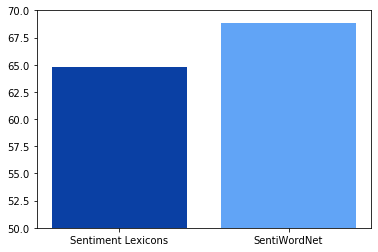

<function matplotlib.pyplot.legend(*args, **kwargs)>

In [19]:
%matplotlib inline

import matplotlib.pyplot as plt

a = ["Sentiment Lexicons", "SentiWordNet"]
index = range(len(a))
b = [64.75, 68.80] # Accuracy scores for the compared methods

fig, ax = plt.subplots()
axes = plt.gca()
# Let's set 50 as the lower bound as the majority class baseline is at 50 for this dataset
axes.set_ylim([50,70])

ax.bar(index, b, color=['#0A40A4', '#61A4F6'])
plt.xticks(index, a) 

plt.show()

import matplotlib
matplotlib.axes.Axes.plot
matplotlib.pyplot.plot
matplotlib.axes.Axes.legend
matplotlib.pyplot.legend

## Data-driven approach with a machine learning classifier

First, let's filter out punctuation marks and stopwords (you can add any other filters if you'd like) and prepare the data for the machine learning pipeline:

In [20]:
import random
import string
#from spacy.lang.en.stop_words import STOP_WORDS as stopwords_list # stopwords list
punctuation_list = [punct for punct in string.punctuation]

def text_filter(a_dict, label, exclude_lists):
    data = []
    for rev_id in a_dict.keys():
        tokens = []
        for token in a_dict.get(rev_id):
            if not token.text in exclude_lists:
                tokens.append(token.text)
                #tokens.append(token.lemma_) # for the use of lemmas instead of word tokens
        data.append((' '.join(tokens), label))
    return data

def prepare_data(pos_docs, neg_docs, exclude_lists):
    data = text_filter(pos_docs, 1, exclude_lists)
    data += text_filter(neg_docs, -1, exclude_lists)
    random.seed(42)
    random.shuffle(data)
    texts = []
    labels = []
    for item in data:
        texts.append(item[0])
        labels.append(item[1])
    return texts, labels

# for the use of both lists in filtering:
#texts, labels = prepare_data(pos_docs, neg_docs, list(stopwords_list) + punctuation_list)

texts, labels = prepare_data(pos_docs, neg_docs, punctuation_list) 

print(len(texts), len(labels))
print(texts[0])

2000 2000
the central focus of michael winterbottom 's welcome to sarajevo is sarajevo itself the city under siege and its different effect on the characters unfortunate enough to be stuck there it proves the backdrop for a stunningly realized story which refreshingly strays from mythic portents platoon racial tumultuosness the risible the walking dead or a tinge of schmaltziness schindler 's list the two leads stephen dillane as a reporter and emira nusevic as an orphan with a plight few can identify with are extremely believable not one moment with them involved rings false the question is not what went right the question is what went wrong for one the film fails to provide a political overview of the war as it progresses the dillane characters reports an american plane departing from sarajevo as it departs and that 's about it the assortment of high profile supporting actors ranging from woody harrelson as a yankee reporter into liquor and cigarrettes to marisa tomei as a huggable c

Note, how the content is filtered down to meaningful words only. Let's set up a small experiment: first set $80\%$ of the data for training and rest for testing in this randomly shuffled set:

In [21]:
def split(texts, labels, proportion):
    train_data = []
    train_targets = []
    test_data = []
    test_targets = []
    for i in range(0, len(texts)):
        if i < proportion*len(texts):
            train_data.append(texts[i])
            train_targets.append(labels[i])
        else:
            test_data.append(texts[i])
            test_targets.append(labels[i])
    return train_data, train_targets, test_data, test_targets

train_data, train_targets, test_data, test_targets = split(texts, labels, 0.8)
        
print(len(train_data)) # 1600?
print(len(train_targets)) # 1600?      
print(len(test_data)) # 400?       
print(len(test_targets)) # 400? 
print(train_targets[:10]) # print out the targets for the first 10 training reviews 
print(test_targets[:10]) # print out the targets for the first 10 test reviews 

1600
1600
400
400
[1, -1, 1, 1, -1, -1, -1, -1, 1, -1]
[-1, 1, 1, -1, -1, 1, -1, 1, 1, 1]


Now, let's estimate the distribution of words across texts using `sklearn`'s `CountVectorizer`. Here is an example of how it will work on a random selection of 1000 reviews:

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
train_counts = count_vect.fit_transform(train_data)
# Check the dimensionality 
print(train_counts.shape)

(1600, 36094)


This shows that our training set contains over $35,000$ distinct words (the exact number may change depending on your split). This is our training set vocabulary, and it will be applied to all test reviews only. Note that this vocabulary is learned on the training data only. Let's look 'under the hood' and print out the counts for some words in the first $10$ reviews from the training set:

In [23]:
print(train_counts[:11])

  (0, 32056)	41
  (0, 5161)	1
  (0, 12240)	1
  (0, 22070)	18
  (0, 20177)	1
  (0, 35454)	2
  (0, 35114)	1
  (0, 32450)	9
  (0, 27596)	3
  (0, 16795)	11
  (0, 16856)	1
  (0, 5707)	1
  (0, 33478)	1
  (0, 28858)	1
  (0, 1445)	16
  (0, 16855)	1
  (0, 8681)	1
  (0, 10024)	1
  (0, 22176)	4
  (0, 5285)	5
  (0, 33682)	1
  (0, 10525)	1
  (0, 2862)	1
  (0, 30800)	1
  (0, 32104)	1
  :	:
  (10, 8382)	1
  (10, 24977)	1
  (10, 18290)	1
  (10, 27020)	1
  (10, 15133)	1
  (10, 13610)	1
  (10, 23180)	1
  (10, 12099)	1
  (10, 24500)	1
  (10, 22155)	1
  (10, 30112)	1
  (10, 30275)	1
  (10, 30764)	1
  (10, 10569)	1
  (10, 14226)	1
  (10, 10259)	1
  (10, 11863)	1
  (10, 30584)	1
  (10, 18070)	1
  (10, 21762)	1
  (10, 33771)	1
  (10, 29624)	1
  (10, 26149)	1
  (10, 2265)	1
  (10, 396)	1


Now, I have the following results: (0, 5240)	5 and (0, 33493)	1. What does it mean? The first review (index 0) contains $5$ occurrences of some word with an index $5240$ and $2$ occurrences of a word with an index $33493$ from the vocabulary. Let's see what those indexes correspond to:

In [24]:
count_vect.get_feature_names()[33682]

'unfortunate'

In [25]:
count_vect.get_feature_names()[30800]

'stuck'

In this particular iteration, index $5240$ corresponds to the word *characters* and index $33493$ to the word *unfortunate*. By the way, according to the `train_targets`, the first review is positive (label `1`). Here is how you can check the whole list:

In [26]:
print(count_vect.inverse_transform(train_data))

[array(['00', '000', '0009f', ..., 'anticipating', 'anticipation',
       'anticlimactic'], dtype='<U32')]


In [27]:
from sklearn.preprocessing import Binarizer

transformer = Binarizer()
train_bin = transformer.fit_transform(train_counts)
print(train_bin.shape)
print(train_bin[0])

(1600, 36094)
  (0, 32056)	1
  (0, 5161)	1
  (0, 12240)	1
  (0, 22070)	1
  (0, 20177)	1
  (0, 35454)	1
  (0, 35114)	1
  (0, 32450)	1
  (0, 27596)	1
  (0, 16795)	1
  (0, 16856)	1
  (0, 5707)	1
  (0, 33478)	1
  (0, 28858)	1
  (0, 1445)	1
  (0, 16855)	1
  (0, 8681)	1
  (0, 10024)	1
  (0, 22176)	1
  (0, 5285)	1
  (0, 33682)	1
  (0, 10525)	1
  (0, 2862)	1
  (0, 30800)	1
  (0, 32104)	1
  :	:
  (0, 32193)	1
  (0, 20907)	1
  (0, 21810)	1
  (0, 10294)	1
  (0, 8110)	1
  (0, 11343)	1
  (0, 16040)	1
  (0, 5659)	1
  (0, 940)	1
  (0, 31239)	1
  (0, 35640)	1
  (0, 25810)	1
  (0, 194)	1
  (0, 11115)	1
  (0, 29672)	1
  (0, 23331)	1
  (0, 16105)	1
  (0, 4658)	1
  (0, 32085)	1
  (0, 1975)	1
  (0, 16595)	1
  (0, 8175)	1
  (0, 28157)	1
  (0, 17325)	1
  (0, 6270)	1


Finally, let's run the classifier on the designated test set: 

In [28]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(train_counts, train_targets)
test_counts = count_vect.transform(test_data)
predicted = clf.predict(test_counts)

for text, label in list(zip(test_data, predicted))[:10]:
    if label==1:
        print('%r => %s' % (text[:100], "pos"))
    else:
        print('%r => %s' % (text[:100], "neg"))

'lengthy and lousy are two words to describe the boring drama the english patient great acting music ' => pos
'capsule a short punchy action sequel to the two dinosaur films made by steven spielberg joe johnston' => neg
'now lets first look into the history of shark films there was the unforgettable jaws the exciting ja' => neg
'five girls spend a day in a closed building doing inventory when a strange box gets delivered there ' => neg
'one sided doom and gloom documentary about the possible annihilation of the human race as foretold b' => neg
"robert redford 's a river runs through it is not a film i watch often it is a masterpiece -- one of " => pos
"susan granger 's review of america 's sweethearts columbia sony what a waste of a talented cast bill" => neg
'  the fugitive is probably one of the greatest thrillers ever made it takes realistic believable cha' => pos
'just look back two years ago at the coen brothers comedic gem the big lebowski change the actors tak' => pos
'plot duri

Alternatively, do the same using `sklearn`'s pipeline: 

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Binarizer

text_clf = Pipeline([('vect', CountVectorizer(min_df=10, max_df=0.5)), 
                     ('binarizer', Binarizer()), # include this for detecting presence-absence of features
                     ('clf', MultinomialNB())
                    ])

text_clf.fit(train_data, train_targets) 
print(text_clf)
predicted = text_clf.predict(test_data)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.5,
                                 max_features=None, min_df=10,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('binarizer', Binarizer(copy=True, threshold=0.0)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)


Evaluate the results:

In [30]:
from sklearn import metrics

print("\nConfusion matrix:")
print(metrics.confusion_matrix(test_targets, predicted))
print(metrics.classification_report(test_targets, predicted))


Confusion matrix:
[[173  29]
 [ 41 157]]
              precision    recall  f1-score   support

          -1       0.81      0.86      0.83       202
           1       0.84      0.79      0.82       198

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400



And now with the cross-validation:

In [31]:
from sklearn.model_selection import cross_val_score, cross_val_predict

scores = cross_val_score(text_clf, texts, labels, cv=10)
print(scores)
print("Accuracy: " + str(sum(scores)/10))
predicted = cross_val_predict(text_clf, texts, labels, cv=10)
print("\nConfusion matrix:")
print(metrics.confusion_matrix(labels, predicted))
print(metrics.classification_report(labels, predicted))

[0.87  0.805 0.87  0.785 0.86  0.82  0.845 0.85  0.81  0.845]
Accuracy: 0.8360000000000001

Confusion matrix:
[[862 138]
 [190 810]]
              precision    recall  f1-score   support

          -1       0.82      0.86      0.84      1000
           1       0.85      0.81      0.83      1000

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



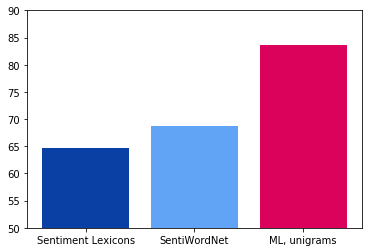

<function matplotlib.pyplot.legend(*args, **kwargs)>

In [42]:
%matplotlib inline

import matplotlib.pyplot as plt

a = ["Sentiment Lexicons", "SentiWordNet", "ML, unigrams"]
index = range(len(a))
b = [64.75, 68.80, 83.60] # Accuracy scores for the compared methods

fig, ax = plt.subplots()
axes = plt.gca()
# Let's set 50 as the lower bound as the majority class baseline is at 50 for this dataset
axes.set_ylim([50,90])

ax.bar(index, b, color=['#0A40A4', '#61A4F6', '#DB025B'])
plt.xticks(index, a) 

plt.show()

import matplotlib
matplotlib.axes.Axes.plot
matplotlib.pyplot.plot
matplotlib.axes.Axes.legend
matplotlib.pyplot.legend

Alternatively, run the `CountVectorizer` on a set of word uni- and bi-grams (with `ngram_range=(1, 2)`) or even uni- + bi- + tri-grams (with `ngram_range=(1, 3)`)

In [54]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 3))), 
                     ('binarizer', Binarizer()), #presence-absence of features
                     ('clf', MultinomialNB())
                    ])

text_clf.fit(train_data, train_targets) 
print(text_clf)
predicted = text_clf.predict(test_data)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('binarizer', Binarizer(copy=True, threshold=0.0)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)


In [55]:
print("\nConfusion matrix:")
print(metrics.confusion_matrix(test_targets, predicted))
print(metrics.classification_report(test_targets, predicted))


Confusion matrix:
[[158  44]
 [ 24 174]]
              precision    recall  f1-score   support

          -1       0.87      0.78      0.82       202
           1       0.80      0.88      0.84       198

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



In [56]:
scores = cross_val_score(text_clf, texts, labels, cv=10)
print(scores)
print("Accuracy: " + str(sum(scores)/10))
predicted = cross_val_predict(text_clf, texts, labels, cv=10)
print("\nConfusion matrix:")
print(metrics.confusion_matrix(labels, predicted))
print(metrics.classification_report(labels, predicted))

[0.89  0.86  0.87  0.835 0.895 0.82  0.86  0.855 0.825 0.88 ]
Accuracy: 0.859

Confusion matrix:
[[810 190]
 [ 92 908]]
              precision    recall  f1-score   support

          -1       0.90      0.81      0.85      1000
           1       0.83      0.91      0.87      1000

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



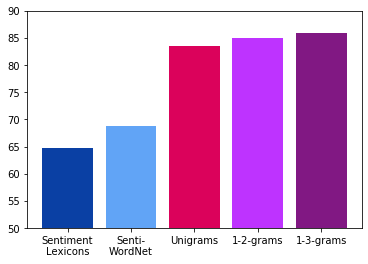

<function matplotlib.pyplot.legend(*args, **kwargs)>

In [49]:
%matplotlib inline

import matplotlib.pyplot as plt

a = ["Sentiment\nLexicons", "Senti-\nWordNet", "Unigrams", "1-2-grams", "1-3-grams"]
index = range(len(a))
b = [64.75, 68.80, 83.60, 85.05, 85.90] # Accuracy scores for the compared methods

fig, ax = plt.subplots()
axes = plt.gca()
# Let's set 50 as the lower bound as the majority class baseline is at 50 for this dataset
axes.set_ylim([50,90])

ax.bar(index, b, color=['#0A40A4', '#61A4F6', '#DB025B', '#BE33FF', '#811883'])
plt.xticks(index, a) 

plt.show()

import matplotlib
matplotlib.axes.Axes.plot
matplotlib.pyplot.plot
matplotlib.axes.Axes.legend
matplotlib.pyplot.legend

### Optional exercise: Consider only pre-defined words as features

You can use selected words (e.g., adjectives identified by their part-of-speech tag or words from specific  sentiment lexicons) only.

First with the lexicons:

In [35]:
def text_filter_incl(a_dict, label, include_lists):
    data = []
    for rev_id in a_dict.keys():
        tokens = []
        for token in a_dict.get(rev_id):
            if token.text in include_lists:
                tokens.append(token.text)
        data.append((' '.join(tokens), label))
    return data

def prepare_data_incl(pos_docs, neg_docs, include_lists):
    data = text_filter_incl(pos_docs, 1, include_lists)
    data += text_filter_incl(neg_docs, -1, include_lists)
    random.shuffle(data)
    texts = []
    labels = []
    for item in data:
        texts.append(item[0])
        labels.append(item[1])
    return texts, labels

#texts_incl, labels_incl = prepare_data(pos_docs, neg_docs, set(list(adj_90.keys()) + list(adj_00.keys())))
texts_incl, labels_incl = prepare_data_incl(pos_docs, neg_docs, 
                                       set(list(adj_90.keys()) + list(adj_00.keys()) + 
                                       list(all_90.keys()) + list(all_00.keys()) + list(movie_words.keys())))

print(len(texts_incl), len(labels_incl))
print(texts_incl[0])

2000 2000
at end an action scene wall near warrior her face floor she into then abruptly says oh my car keys mention scene because only moment whole damned production made me smile based an incredibly popular video game lousy movie structure goes poorly action sequence boring exposition poorly action sequence boring exposition etc etc end basically film exists jolie puffy lips tits close ups framed oh carefully include her million dollar running scenes highlight her breasts fashion there even include shower scene offers brief side view them filmmakers ca even flash audience correctly one extended display nudity get ready guy no particular reason muscular supporting character around naked about 30 seconds each shot barely cover his package la austin powers now enjoy good looking male body much next gay guy what hell doing flick aimed at males course what else should one expect film does virtually nothing right sets up elaborate action set pieces then them incomprehensible needless jump 

In [36]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))), 
                     #options: ngram_range=(1, 2) or min_df=10, max_df=0.5
                     ('binarizer', Binarizer()), #presence-absence of features
                     ('clf', MultinomialNB()),
                    ])

print(text_clf)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('binarizer', Binarizer(copy=True, threshold=0.0)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)


In [37]:
scores = cross_val_score(text_clf, texts_incl, labels_incl, cv=10)
print(scores)
print("Accuracy: " + str(sum(scores)/10))
predicted = cross_val_predict(text_clf, texts_incl, labels_incl, cv=10)
print("\nConfusion matrix:")
print(metrics.confusion_matrix(labels_incl, predicted))
print(metrics.classification_report(labels_incl, predicted))

[0.88  0.82  0.87  0.835 0.85  0.885 0.87  0.82  0.855 0.865]
Accuracy: 0.8550000000000001

Confusion matrix:
[[830 170]
 [120 880]]
              precision    recall  f1-score   support

          -1       0.87      0.83      0.85      1000
           1       0.84      0.88      0.86      1000

    accuracy                           0.85      2000
   macro avg       0.86      0.85      0.85      2000
weighted avg       0.86      0.85      0.85      2000



And now with the part-of-speech tags:

In [38]:
def text_filter_postag(a_dict, label, pos_lists):
    data = []
    for rev_id in a_dict.keys():
        tokens = []
        for token in a_dict.get(rev_id):
            if token.pos_ in pos_lists:
                tokens.append(token.text)
        data.append((' '.join(tokens), label))
    return data

def prepare_data_postag(pos_docs, neg_docs, pos_lists):
    data = text_filter_postag(pos_docs, 1, pos_lists)
    data += text_filter_postag(neg_docs, -1, pos_lists)
    random.shuffle(data)
    texts = []
    labels = []
    for item in data:
        texts.append(item[0])
        labels.append(item[1])
    return texts, labels

texts_postag, labels_postag = prepare_data_postag(pos_docs, neg_docs, ["ADJ", "ADV"])

print(len(texts_postag), len(labels_postag))
print(texts_postag[0])

2000 2000
last sore when not aloud virtually n't as much second first great goofy dandy energetic inspired flat most fun zippy retro straight slapstick then extremely rich venetian unusual high half very special together lucky where simple n there ahead first wrong next few flashy trashy big erudite conservative more little wary together clear fierce competitive currently most hated all enormous high vengeful new cheerful odd little italian also narcoleptic asleep most inopportune wayne hyper tense human fearful angry together so mini green young crooked stupid poorly only close finally smart first blandly wholesome when periodically where right bizarre few flat high intricately bizarre outdoor utterly tasteless screamingly funny filmmaking where instead same also different really yet smash enough terrific diverse again when hilarious surely


In [39]:
scores = cross_val_score(text_clf, texts_postag, labels_postag, cv=10)
print(scores)
print("Accuracy: " + str(sum(scores)/10))
predicted = cross_val_predict(text_clf, texts_postag, labels_postag, cv=10)
print("\nConfusion matrix:")
print(metrics.confusion_matrix(labels_postag, predicted))
print(metrics.classification_report(labels_postag, predicted))

[0.845 0.875 0.845 0.875 0.855 0.82  0.85  0.81  0.82  0.865]
Accuracy: 0.8460000000000001

Confusion matrix:
[[828 172]
 [136 864]]
              precision    recall  f1-score   support

          -1       0.86      0.83      0.84      1000
           1       0.83      0.86      0.85      1000

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



## Addressing negation

Use NLTK's negation "trick":

In [57]:
from nltk.sentiment.util import mark_negation

def text_filter_neg(a_dict, label, exclude_lists):
    data = []
    for rev_id in a_dict.keys():
        tokens = []
        for sent in a_dict.get(rev_id).sents:
            neg_tokens = mark_negation(sent.text.split())
            #print (neg_tokens)
            for token in neg_tokens:
                if not token in exclude_lists:
                    tokens.append(token)
        data.append((' '.join(tokens), label))
    return data

def prepare_data_neg(pos_docs, neg_docs, exclude_lists):
    data = text_filter_neg(pos_docs, 1, exclude_lists)
    data += text_filter_neg(neg_docs, -1, exclude_lists)
    random.seed(42)
    random.shuffle(data)
    texts = []
    labels = []
    for item in data:
        texts.append(item[0])
        labels.append(item[1])
    return texts, labels


texts_neg, labels_neg = prepare_data_neg(pos_docs, neg_docs, punctuation_list) 

print(len(texts_neg), len(labels_neg))
print(texts_neg[0])

2000 2000
the central focus of michael winterbottom's welcome to sarajevo is sarajevo itself the city under siege and its different effect on the characters unfortunate enough to be stuck there it proves the backdrop for a stunningly realized story which refreshingly strays from mythic portents platoon racial tumultuosness the risible the walking dead or a tinge of schmaltziness schindler's list the two leads stephen dillane as a reporter and emira nusevic as an orphan with a plight few can identify with are extremely believable not one_NEG moment_NEG with_NEG them_NEG involved_NEG rings_NEG false_NEG the question is not what_NEG went_NEG right_NEG the question is what went wrong for one the film fails to provide a political overview of the war as it progresses the dillane characters reports an american plane departing from sarajevo as it departs and that's about it the assortment of high-profile supporting actors ranging from woody harrelson as a yankee reporter into liquor and cigarr

In [62]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))), 
                     #options: ngram_range=(1, 2) or min_df=10, max_df=0.5
                     ('binarizer', Binarizer()), #presence-absence of features
                     ('clf', MultinomialNB()),
                    ])

scores = cross_val_score(text_clf, texts_neg, labels_neg, cv=10)
print(scores)
print("Accuracy: " + str(sum(scores)/10))
predicted = cross_val_predict(text_clf, texts_neg, labels_neg, cv=10)
print("\nConfusion matrix:")
print(metrics.confusion_matrix(labels_neg, predicted))
print(metrics.classification_report(labels_neg, predicted))

[0.89  0.865 0.875 0.82  0.895 0.8   0.855 0.885 0.82  0.88 ]
Accuracy: 0.8585

Confusion matrix:
[[828 172]
 [111 889]]
              precision    recall  f1-score   support

          -1       0.88      0.83      0.85      1000
           1       0.84      0.89      0.86      1000

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



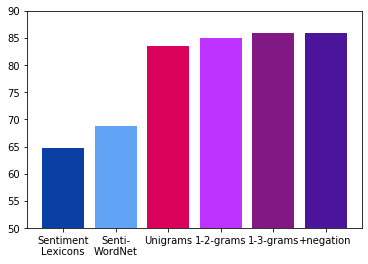

<function matplotlib.pyplot.legend(*args, **kwargs)>

In [66]:
%matplotlib inline

import matplotlib.pyplot as plt

a = ["Sentiment\nLexicons", "Senti-\nWordNet", "Unigrams", "1-2-grams", "1-3-grams", "+negation"]
index = range(len(a))
b = [64.75, 68.80, 83.60, 85.05, 85.90, 85.85] # Accuracy scores for the compared methods

fig, ax = plt.subplots()
axes = plt.gca()
# Let's set 50 as the lower bound as the majority class baseline is at 50 for this dataset
axes.set_ylim([50,90])

ax.bar(index, b, color=['#0A40A4', '#61A4F6', '#DB025B', '#BE33FF', '#811883', '#4B169C'])
plt.xticks(index, a) 

plt.show()

import matplotlib
matplotlib.axes.Axes.plot
matplotlib.pyplot.plot
matplotlib.axes.Axes.legend
matplotlib.pyplot.legend